Given $n$ distinct objects in the bag, we take one object at a time, and then put it back. The process stops when we take an object that has been previously selected.

Let $T(n)$ represent the number of steps required for the process to terminate.
That is, $T(n)$-th sample is the first time we select an object that has already been selected.

For example, let $n=5$; enumerate the objects as $1,2,3,4,5$. The process could go as follows: `[1, 4, 3, 4]`. Then $T(5) = 4$.

now let $e(n) = \mathbb{E}[T(n)]$ (the expected value of $T(n)$).

Find $e(n)$.

In [1]:
import math
import random

import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6, 4)


def run_first_repeat_at(n: int) -> int:
    seen = set()
    while True:
        sample = random.randint(1, n)
        if sample in seen:
            return len(seen) + 1
        seen.add(sample)


def run_first_repeat_at_avg(n: int, num_trials) -> float:
    return sum(run_first_repeat_at(n) for _ in range(num_trials)) / num_trials

In [2]:
ns = list(range(1, 100))
simulated_values = [run_first_repeat_at_avg(n, num_trials=10_000) for n in ns]

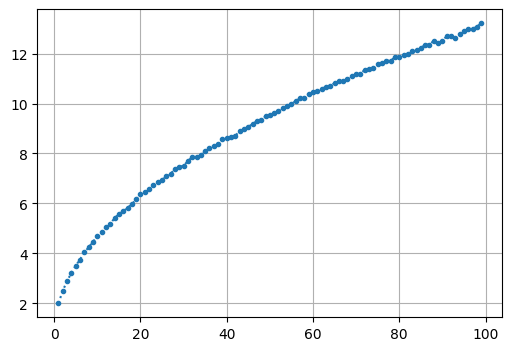

In [3]:
plt.plot(ns, simulated_values, '.:')
plt.grid()
plt.show()

Let us derive the formula for the expected $k$ of the first repeat.

Given $n$, let $p_k$ be the probability that there are no repeats during the first $k$ steps. This is closely related to a so-called birthday problem:
$$
p_k = 1 \cdot \frac{n-1}{n} \cdot \frac{n-2}{n} \cdot \ldots \cdot \frac{n-k+1}{n} = \frac{1}{n^{k-1}} \prod_{i=1}^{k-1} (n-i) = \prod_{i=1}^{k-1} \left(1 - \frac{i}{n}\right) = \frac{(n-1)!}{(n-k)! n^{k-1}}
$$


Then the probability $q_k$ that the first repeat occurs at step $k$ is equivalent to "there are no repeats in the first $k-1$ steps" and "there is a repeat at step $k$":

$$
q_k = p_{k-1} \cdot \frac{k-1}{n}
$$

Then, the expected value of the first repeat is, by definition:
$$
e(n) = \sum_{k=1}^{n+1} k q_k = \frac{1}{n} \sum_{k=1}^{n+1}
 k(k-1) \prod_{i=1}^{k-2} \left(1 - \frac{i}{n}\right) = \sum_{k=1}^{n+1} \frac{k(k-1)(n-1)!}{(n-k+1)!\,n^{k-1}}
$$


Let us summarize the derivation using `sympy`.

In [4]:
i, k, n = sp.symbols("i k n")

p = sp.Product((1 - i / n), (i, 1, k - 1))
p

Product(-i/n + 1, (i, 1, k - 1))

In [5]:
q = p.subs({k: k - 1}) * (k - 1) / n
q

(k - 1)*Product(-i/n + 1, (i, 1, k - 2))/n

In [6]:
k_expected = sp.Sum(k * q, (k, 2, n))
k_expected

Sum(k*(k - 1)*Product(-i/n + 1, (i, 1, k - 2))/n, (k, 2, n))

Now, let us calculate $e(n)$ from the formula above and compare it with the simulation results.

In [7]:
def prob_no_repeat_for_k(k: int, n: int) -> float:
    return math.prod((1 - i / n) for i in range(1, k))


def prob_first_repeat_at_kth(k: int, n: int) -> float:
    return prob_no_repeat_for_k(k - 1, n) * (k - 1) / n


def expected_first_repeat(n: int) -> float:
    return sum(k * prob_first_repeat_at_kth(k, n) for k in range(2, n+2))

In [8]:
analytical_values = [expected_first_repeat(n) for n in ns]

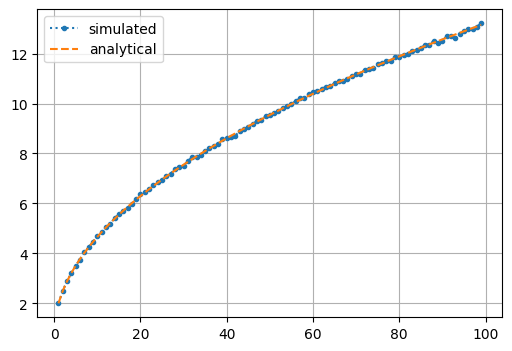

In [9]:
plt.plot(ns, simulated_values, '.:', label="simulated")
plt.plot(ns, analytical_values, '--', label="analytical")
plt.grid()
plt.legend()
plt.show()

## Best* fit

Note that $f(n) = K \sqrt{n} + B$ is a good fit for the expected $k$ of the first repeat.

In [10]:
ns_np = np.arange(1, 500)
analytical_values_np = np.array([expected_first_repeat(n) for n in ns_np])

K, B = np.polyfit(np.sqrt(ns_np), analytical_values_np, 1)
print(f"e(n) = {K:.3f} * sqrt(n) + {B:.3f}")

fit_values = K * np.sqrt(ns_np) + B

e(n) = 1.252 * sqrt(n) + 0.690


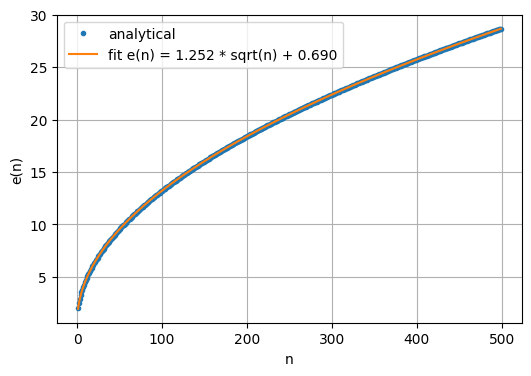

In [11]:
plt.plot(ns_np, analytical_values_np, '.', label="analytical")
plt.plot(ns_np, fit_values, '-', label=f"fit e(n) = {K:.3f} * sqrt(n) + {B:.3f}")
plt.grid()
plt.xlabel("n")
plt.ylabel("e(n)")
plt.legend()
plt.show()

Open questions: 
- why is this such a good fit? 
- what are the fit parameters? do they have a closed form?